In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import os
import sys
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)



True

In [2]:
#checking files present
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
#Loading the Safaricom tweets dataset
saf_tweets=pd.read_csv('saf_tweets.csv')
#Displaying the first few rows of the dataset
saf_tweets.head()


,Tweet ID,URL,Content,Likes,Retweets,Replies,Quotes,Views,Date,Labels
0,1.950000e+18,https://x.com/MawiaDorothy/status/194955836816...,How comes I have overdue debts.. na sijakopa.....,1,0,0,0,21,"July 27, 2025 at 07:51 PM",Customer care complaint
1,1.950000e+18,https://x.com/KruiGeofrey/status/1949310365839...,@Monty_Hasashi @Safaricom 😂😂,0,0,0,0,22,"July 27, 2025 at 03:26 AM",Neutral
2,1.950000e+18,https://x.com/martozgicha/status/1949022872242...,"@safaricom weka data ,wacheni jokes...Thank yo...",0,0,0,0,6,"July 26, 2025 at 08:23 AM",Internet or airtime bundle complaint
3,1.950000e+18,https://x.com/liyansmutembei/status/1948476756...,@SafaricomPLC Hello @SafaricomPLC @safaricom...,0,0,0,0,47,"July 24, 2025 at 08:13 PM",Customer care complaint
4,1.950000e+18,https://x.com/SsirNixoNdugire/status/194833516...,@PeterNdegwa_ @SafaricomPLC @Safaricom_Care @S...,0,0,0,0,5,"July 24, 2025 at 10:51 AM",Customer care complaint


In [4]:
#checking info
saf_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2574 entries, 0 to 2573
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tweet ID  2574 non-null   float64
 1   URL       2574 non-null   object 
 2   Content   2574 non-null   object 
 3   Likes     2574 non-null   int64  
 4   Retweets  2574 non-null   int64  
 5   Replies   2574 non-null   int64  
 6   Quotes    2574 non-null   int64  
 7   Views     2574 non-null   int64  
 8   Date      2574 non-null   object 
 9   Labels    2573 non-null   object 
dtypes: float64(1), int64(5), object(4)
memory usage: 201.2+ KB


In [5]:
#Check unique counts in labels
saf_tweets['Labels'].value_counts()

Neutral                                 1032
Customer care complaint                  397
Internet or airtime bundle complaint     299
Hate Speech                              297
MPESA complaint                          189
Network reliability problem              184
Data protection and privacy concern      175
Name: Labels, dtype: int64

In [6]:
#Check for duplicated values
saf_tweets.duplicated().sum()

0

### Data cleaning and preparation

##### Contradiction dictionary

In [7]:
# Global tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Contractions dictionary
contractions = {
    "won't": "will not", "can't": "cannot", "n't": " not",
    "'re": " are", "'ve": " have", "'ll": " will",
    "'d": " would", "'m": " am", "it's": "it is",
    "that's": "that is", "what's": "what is",
    "there's": "there is", "here's": "here is"
}

In [8]:
def expand_contractions_text(text, contractions=contractions):
    """Expand contractions in the text."""
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    return text


#### Removing repeated characters

In [9]:
def remove_repeated_characters(text):
    """Reduce repeated characters (e.g., soooo → soo)."""
    return re.sub(r'(.)\1{2,}', r'\1\1', text)


##### Basic cleaning function

In [10]:
def basic_cleaning(text, 
                   remove_urls=True,
                   remove_mentions=True,
                   remove_hashtags=True):
    """Apply basic regex cleaning to text."""
    if pd.isna(text):
        return ''
    
    text = str(text)

    if remove_urls:
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    if remove_mentions:
        text = re.sub(r'@\w+', '', text)

    if remove_hashtags:
        text = re.sub(r'#', '', text)

    text = re.sub(r'[^a-zA-Z\s!?]', '', text)  # Remove special chars but keep ! ?
    text = re.sub(r'!+', '!', text)
    text = re.sub(r'\?+', '?', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [11]:
def clean_text_pipeline(text,
                        expand_contractions=True,
                        remove_repeated_chars=True,
                        remove_urls=True,
                        remove_mentions=True,
                        remove_hashtags=True):
    """Complete cleaning pipeline (no tokenizing or lemmatizing)."""
    if pd.isna(text):
        return ''
    
    text = str(text)

    if expand_contractions:
        text = expand_contractions_text(text)
    
    if remove_repeated_chars:
        text = remove_repeated_characters(text)

    text = basic_cleaning(
        text,
        remove_urls=remove_urls,
        remove_mentions=remove_mentions,
        remove_hashtags=remove_hashtags
    )

    return text


## Testing if it has worked with some tweets

In [12]:
tweets = [
    "My @safaricom network is misbehaving",
    "@safaricom rudisheni hii na mnipee bundles .sasa sms nazifanyia nini https://t.co/CvaD1kd5wM",
    "@Shikanda_00 @safaricom",
    "@safaricom you are a scam https://t.co/80BRkJ5uB2"
]

for t in tweets:
    print("Cleaned:", clean_text_pipeline(t))


Cleaned: My network is misbehaving
Cleaned: rudisheni hii na mnipee bundles sasa sms nazifanyia nini
Cleaned: 
Cleaned: you are a scam


In [13]:
## testing it on the Safaricom tweets dataset
saf_tweets['Cleaned_Text'] = saf_tweets['Content'].apply(clean_text_pipeline)

In [14]:
saf_tweets[['Content', 'Cleaned_Text']].head(10)

,Content,Cleaned_Text
0,How comes I have overdue debts.. na sijakopa.....,How comes I have overdue debts na sijakopawhat...
1,@Monty_Hasashi @Safaricom 😂😂,
2,"@safaricom weka data ,wacheni jokes...Thank yo...",weka data wacheni jokesThank you for being par...
3,@SafaricomPLC Hello @SafaricomPLC @safaricom...,Hello can you borrow from Airtel and allow man...
4,@PeterNdegwa_ @SafaricomPLC @Safaricom_Care @S...,Jambo Kindly consider introducing a Narration ...
5,"Update: @Safaricom PLC (NSE: SCOM), has annou...",Update PLC NSE SCOM has announced a historic m...
6,"Customer Growth: 50M Connected, The @Safaricom...",Customer Growth M Connected The story proves o...
7,"Through the @Safaricom and M-PESA Foundations,...",Through the and MPESA Foundations M Kenyans ha...
8,"In the last financial year, @Safaricom contrib...",In the last financial year contributed KES B t...
9,"Beyond Kenya, @Safaricom is also winning in Et...",Beyond Kenya is also winning in Ethiopia As of...


In [15]:
saf_tweets[['Content', 'Cleaned_Text']].to_csv('saf_tweets_cleaned.csv', index=False)


### Expand Contractions
Contractions like "can't", "won't", "I'm" should be expanded to "cannot", "will not", "I am" — this helps with better tokenization and modeling.

We’ll use the contractions library for this.

In [16]:
pip install contractions


Note: you may need to restart the kernel to use updated packages.


In [17]:
import contractions

def expand_contractions(text):
    if isinstance(text, str):
        return contractions.fix(text)
    else:
        return ""

# Apply to Cleaned_Text column
saf_tweets['Cleaned_Text'] =saf_tweets['Cleaned_Text'].apply(expand_contractions)

# Preview
saf_tweets[['Content', 'Cleaned_Text']].head(10)


,Content,Cleaned_Text
0,How comes I have overdue debts.. na sijakopa.....,How comes I have overdue debts na sijakopawhat...
1,@Monty_Hasashi @Safaricom 😂😂,
2,"@safaricom weka data ,wacheni jokes...Thank yo...",weka data wacheni jokesThank you for being par...
3,@SafaricomPLC Hello @SafaricomPLC @safaricom...,Hello can you borrow from Airtel and allow man...
4,@PeterNdegwa_ @SafaricomPLC @Safaricom_Care @S...,Jambo Kindly consider introducing a Narration ...
5,"Update: @Safaricom PLC (NSE: SCOM), has annou...",Update PLC NSE SCOM has announced a historic m...
6,"Customer Growth: 50M Connected, The @Safaricom...",Customer Growth M Connected The story proves o...
7,"Through the @Safaricom and M-PESA Foundations,...",Through the and MPESA Foundations M Kenyans ha...
8,"In the last financial year, @Safaricom contrib...",In the last financial year contributed KES B t...
9,"Beyond Kenya, @Safaricom is also winning in Et...",Beyond Kenya is also winning in Ethiopia As of...


### Tokenization and Lemmatization
In this step, we prepared our cleaned tweet text for machine learning by breaking it into individual words and reducing each word to its base form.

 What We Did:
Tokenization: Split each tweet into individual words (tokens) using NLTK's word_tokenize.

Lowercasing: Converted all tokens to lowercase for consistency.

Stopword Removal: Removed common English words like "is", "the", "and", which do not contribute meaningful information for classification.

Alphabetic Filtering: Removed numbers, punctuation, and non-alphabetic characters.

Lemmatization: Converted each token to its root dictionary form using WordNetLemmatizer.
For example:

"running", "ran", "runs" → "run"



In [18]:
def tokenize_and_lemmatize(text):
    if isinstance(text, str):
        tokens = word_tokenize(text.lower())  # Tokenize and lowercase
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]
        return ' '.join(tokens)
    return ""

# Apply to the cleaned column
saf_tweets['Processed_Text'] = saf_tweets['Cleaned_Text'].apply(tokenize_and_lemmatize)

# Preview result
saf_tweets[['Content', 'Cleaned_Text', 'Processed_Text']].head()


,Content,Cleaned_Text,Processed_Text
0,How comes I have overdue debts.. na sijakopa.....,How comes I have overdue debts na sijakopawhat...,come overdue debt na sijakopawhat happening
1,@Monty_Hasashi @Safaricom 😂😂,,
2,"@safaricom weka data ,wacheni jokes...Thank yo...",weka data wacheni jokesThank you for being par...,weka data wacheni jokesthank part journey toda...
3,@SafaricomPLC Hello @SafaricomPLC @safaricom...,Hello can you borrow from Airtel and allow man...,hello borrow airtel allow management one safar...
4,@PeterNdegwa_ @SafaricomPLC @Safaricom_Care @S...,Jambo Kindly consider introducing a Narration ...,jambo kindly consider introducing narration he...


## Text Vectorization: Converting Tweets into Numeric Features

To prepare our processed tweet text for machine learning, we need to convert it into a numerical format. This is done using **vectorization**, where each tweet is represented by a vector of numbers based on the words it contains.

We apply two different vectorization techniques:

- **CountVectorizer**: This method counts how many times each word appears in a tweet. The result is a sparse matrix where each column represents a word from the vocabulary and each row represents a tweet.

- **TfidfVectorizer (Term Frequency-Inverse Document Frequency)**: This method does more than just count. It also considers how *unique* a word is across all tweets. Common words (like "the", "and") get lower scores, while rare but meaningful words get higher scores. This helps improve the performance of machine learning models.

We apply both methods separately to generate two sets of features:
- One using raw word counts
- One using TF-IDF scores

This allows us to compare how different vectorization strategies affect model performance.


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vect = CountVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the processed text
X_count = count_vect.fit_transform(saf_tweets['Processed_Text'])

# Optional: convert to DataFrame
count_df = pd.DataFrame(X_count.toarray(), columns=count_vect.get_feature_names())

# Preview
count_df.head(100)


,abandon,abandon snitcher,abduct,abducted,abducted killed,abducting,abduction,abductor,able,able access,...,ziidi mmf,ziko,zile,zimbabwe,zimebaki,zinaisha,zingine,zote,zuku,zuri
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
saf_tweets[['Content', 'Cleaned_Text', 'Processed_Text']].head(10)


,Content,Cleaned_Text,Processed_Text
0,How comes I have overdue debts.. na sijakopa.....,How comes I have overdue debts na sijakopawhat...,come overdue debt na sijakopawhat happening
1,@Monty_Hasashi @Safaricom 😂😂,,
2,"@safaricom weka data ,wacheni jokes...Thank yo...",weka data wacheni jokesThank you for being par...,weka data wacheni jokesthank part journey toda...
3,@SafaricomPLC Hello @SafaricomPLC @safaricom...,Hello can you borrow from Airtel and allow man...,hello borrow airtel allow management one safar...
4,@PeterNdegwa_ @SafaricomPLC @Safaricom_Care @S...,Jambo Kindly consider introducing a Narration ...,jambo kindly consider introducing narration he...
5,"Update: @Safaricom PLC (NSE: SCOM), has annou...",Update PLC NSE SCOM has announced a historic m...,update plc nse scom announced historic milesto...
6,"Customer Growth: 50M Connected, The @Safaricom...",Customer Growth M Connected The story proves o...,customer growth connected story prof one thing...
7,"Through the @Safaricom and M-PESA Foundations,...",Through the and MPESA Foundations M Kenyans ha...,mpesa foundation kenyan benefited project educ...
8,"In the last financial year, @Safaricom contrib...",In the last financial year contributed KES B t...,last financial year contributed kes b kenyan e...
9,"Beyond Kenya, @Safaricom is also winning in Et...",Beyond Kenya is also winning in Ethiopia As of...,beyond kenya also winning ethiopia july operat...


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the same text
X_tfidf = tfidf_vect.fit_transform(saf_tweets['Processed_Text'])

# Optional: convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vect.get_feature_names())

# Preview
tfidf_df.head(250)


,abandon,abandon snitcher,abduct,abducted,abducted killed,abducting,abduction,abductor,able,able access,...,ziidi mmf,ziko,zile,zimbabwe,zimebaki,zinaisha,zingine,zote,zuku,zuri
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Verifying Vectorization Results

To ensure that our text vectorization worked correctly, we preview the transformed data. Specifically, we:

- Display a few rows from the resulting feature matrix to confirm the shape and structure.
- Check if the vectorized data reflects the expected word presence or absence per tweet.
- Ensure that the output contains non-zero values for tweets that include words from our vocabulary.

Each row in the output corresponds to a tweet, and each column represents a word. A non-zero entry shows that the word appears in that tweet (or its importance score, in the case of TF-IDF).

This verification step helps confirm that the tweets have been correctly transformed into numerical format and are now ready to be used as input features for machine learning models.


In [22]:
# Total non-zero elements in the whole matrix
#This shows how many words are detected by the count vectorizer
X_count.toarray().sum()


24172

In [23]:
# Count of non-zero tokens per tweet
# This code shows total words remaining from index 0 after cleaning and tekenizing
np.count_nonzero(X_count.toarray(), axis=1)


array([ 5,  0, 12, ...,  2, 23, 22], dtype=int64)

In [24]:
# Check tweets with the most recognized words
nonzero_counts = np.count_nonzero(X_count.toarray(), axis=1)
top_indices = nonzero_counts.argsort()[-5:][::-1]  # Top 5 tweets with most tokens

# Preview them
saf_tweets.iloc[top_indices][["Content", "Processed_Text"]]


,Content,Processed_Text
307,In delivering on our maternal and general heal...,delivering maternal general healthcare service...
304,In delivering on our maternal and general heal...,delivering maternal general healthcare service...
2373,📢Calling upon all our students in the School o...,calling upon student school science technology...
2154,@Safaricom_Care Thanks for your good network @...,thanks good network big problem physical custo...
2153,@Safaricom_Care @Ianolinmaina99 Thanks for you...,thanks good network big problem physical custo...


In [25]:
#This code tells you which words appeared in that tweet and how many times each word occurred.
# Pick a row (e.g., 307)
row_index = 307

# Get non-zero tokens and their counts
row = X_count[row_index].toarray()[0]
tokens = np.array(count_vect.get_feature_names())

# Show only tokens that appear (count > 0)
token_counts = {token: count for token, count in zip(tokens, row) if count > 0}
token_counts


{'alongside': 1,
 'alongside modern': 1,
 'centre': 1,
 'centre sigomre': 1,
 'commence': 1,
 'commence construction': 1,
 'construction': 1,
 'construction new': 1,
 'continue': 1,
 'continue undertake': 1,
 'delivering': 1,
 'delivering maternal': 1,
 'enhance': 1,
 'enhance improve': 1,
 'equipped': 1,
 'equipped maternity': 1,
 'facility': 1,
 'foundation': 2,
 'foundation stone': 1,
 'foundation tingare': 1,
 'general': 1,
 'general healthcare': 1,
 'get': 1,
 'get modern': 1,
 'health': 2,
 'health centre': 1,
 'health reduce': 1,
 'healthcare': 2,
 'healthcare infrastructure': 1,
 'healthcare service': 1,
 'improve': 2,
 'improve healthcare': 1,
 'improve maternal': 1,
 'infrastructure': 1,
 'infrastructure partnership': 1,
 'join': 1,
 'join tomorrow': 1,
 'laboratory': 1,
 'laboratory join': 1,
 'lay': 1,
 'lay foundation': 1,
 'maternal': 2,
 'maternal general': 1,
 'maternal health': 1,
 'maternity': 1,
 'maternity unit': 1,
 'modern': 2,
 'modern laboratory': 1,
 'modern we

### Split your data:

Use train_test_split() to separate into training and test sets.

2. Train & evaluate traditional ML models:

Logistic Regression

Multinomial Naive Bayes

Evaluate using accuracy, F1-score, confusion matrix

3. Move to transformer-based models (XLM-R & mBERT):

Tokenize with HuggingFace tokenizer

Fine-tune using transformers library

Use Trainer API or manual training loop

Evaluate performance



### Splitting data
We split data to test model performance fairly, and we ensure X and y match so that each input has a correct target label during training.


In [26]:
saf_tweets.columns


Index(['Tweet ID', 'URL', 'Content', 'Likes', 'Retweets', 'Replies', 'Quotes',
       'Views', 'Date', 'Labels', 'Cleaned_Text', 'Processed_Text'],
      dtype='object')

In [27]:
saf_tweets['Labels'].unique()


array(['Customer care complaint', 'Neutral',
       'Internet or airtime bundle complaint', 'Hate Speech',
       'Data protection and privacy concern',
       'Network reliability problem', 'MPESA complaint', nan],
      dtype=object)

In [28]:
saf_tweets['Labels'].isnull().sum()


1

In [29]:
saf_tweets = saf_tweets.dropna(subset=['Labels'])


In [30]:
# Feature matrix (X) from TF-IDF
X = X_tfidf  # or use X_count if you're working with CountVectorizer

# Target labels
y = saf_tweets['Labels']


In [31]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2574, 5000)
y shape: (2573,)


### Here we drop rows with missing labels, we need to ensure that our feature matrix X had the same number of rows as the label vector y. So we regenerated X using the updated saf_tweets DataFram

In [32]:
# Drop rows with missing labels
saf_tweets = saf_tweets.dropna(subset=['Labels'])

# Confirm the new shape
print("After dropping, saf_tweets shape:", saf_tweets.shape)


After dropping, saf_tweets shape: (2573, 12)


In [33]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2574, 5000)
y shape: (2573,)


In [34]:
X = tfidf_vect.transform(saf_tweets["Processed_Text"])


In [35]:
# Here we are confirming if our rows are equal the we can model
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2573, 5000)
y shape: (2573,)


In [36]:
from sklearn.model_selection import train_test_split

# Split the dataset (assuming X and y are already cleaned and aligned)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Modelling

### Now we begin with Logistic regression
We trained a Logistic Regression model using the training data.

Evaluated its performance using:

Accuracy Score to measure overall correctness.

Confusion Matrix to visualize how well the model predicted each category.

Classification Report to analyze precision, recall, and F1-score for each class.

Key Takeaways:

The model achieved an accuracy of 57%.

It predicted the 'Neutral' class well but struggled with less frequent categories.

Precision and recall were low for most complaint types, suggesting that improvements are needed.

In [37]:
# I mport and Train Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# 2. Fit (train) the model using training data
log_reg.fit(X_train, y_train)

# 3. Predict labels for the test set
y_pred = log_reg.predict(X_test)

# 4. Evaluate model performance
print("Accuracy Score:", accuracy_score(y_test, y_pred))  # Overall accuracy
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))  # Breakdown of predictions
print("\nClassification Report:\n", classification_report(y_test, y_pred))  # Precision, recall, F1


Accuracy Score: 0.5728155339805825

Confusion Matrix:
 [[ 28   0   0   3   1   0  47]
 [  4   4   2   0   0   0  25]
 [  1   0  17   0   0   1  40]
 [  2   0   0  28   0   1  29]
 [  3   0   1   0  16   0  18]
 [  3   0   1   6   0   7  20]
 [  9   0   0   0   3   0 195]]

Classification Report:
                                       precision    recall  f1-score   support

             Customer care complaint       0.56      0.35      0.43        79
 Data protection and privacy concern       1.00      0.11      0.21        35
                         Hate Speech       0.81      0.29      0.43        59
Internet or airtime bundle complaint       0.76      0.47      0.58        60
                     MPESA complaint       0.80      0.42      0.55        38
         Network reliability problem       0.78      0.19      0.30        37
                             Neutral       0.52      0.94      0.67       207

                            accuracy                           0.57       51

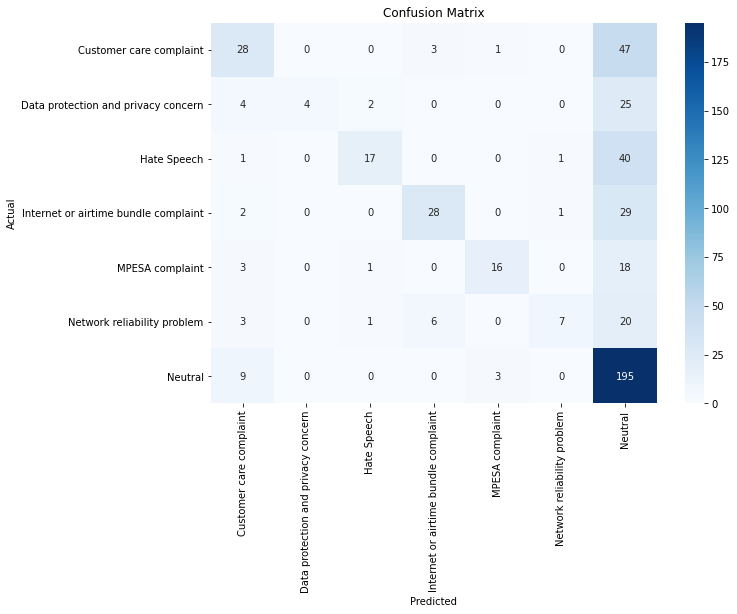

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the actual label names
labels = np.unique(y_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Naive Bayes for Multiclass Classification

In [39]:
from sklearn.naive_bayes import MultinomialNB # this is well suited for text data(FT-IDF)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Initialize the Naive Bayes classifier
nb_model = MultinomialNB()

# 2. Fit the model to the training data
nb_model.fit(X_train, y_train)

# 3. Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# 4. Evaluate the model
accuracy = accuracy_score(y_test, y_pred_nb)
print("Accuracy Score:", accuracy)

# 5. Display the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

# 6. Print a detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))


Accuracy Score: 0.48349514563106794

Confusion Matrix:
 [[ 14   0   0   1   0   0  64]
 [  1   0   0   0   0   0  34]
 [  2   0  12   0   0   0  45]
 [  1   0   0  15   0   0  44]
 [  2   0   0   0   3   0  33]
 [  1   0   0   4   0   1  31]
 [  3   0   0   0   0   0 204]]

Classification Report:
                                       precision    recall  f1-score   support

             Customer care complaint       0.58      0.18      0.27        79
 Data protection and privacy concern       0.00      0.00      0.00        35
                         Hate Speech       1.00      0.20      0.34        59
Internet or airtime bundle complaint       0.75      0.25      0.38        60
                     MPESA complaint       1.00      0.08      0.15        38
         Network reliability problem       1.00      0.03      0.05        37
                             Neutral       0.45      0.99      0.62       207

                            accuracy                           0.48       5

c:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


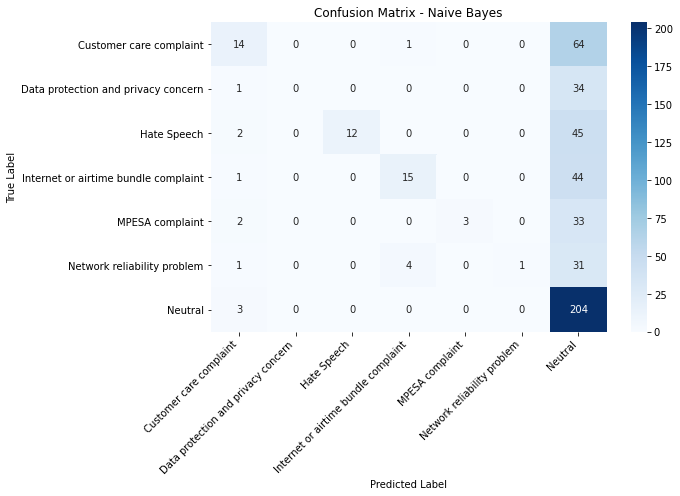

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define your class labels in the correct order
class_names = [
    "Customer care complaint",
    "Data protection and privacy concern",
    "Hate Speech",
    "Internet or airtime bundle complaint",
    "MPESA complaint",
    "Network reliability problem",
    "Neutral"
]

# Generate the confusion matrix
nb_cm = confusion_matrix(y_test, y_pred_nb)

# Plot the confusion matrix heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Random Forest

Accuracy Score: 0.6

Classification Report:
                                       precision    recall  f1-score   support

             Customer care complaint       0.45      0.29      0.35        79
 Data protection and privacy concern       1.00      0.26      0.41        35
                         Hate Speech       0.74      0.39      0.51        59
Internet or airtime bundle complaint       0.65      0.67      0.66        60
                     MPESA complaint       0.62      0.53      0.57        38
         Network reliability problem       0.65      0.46      0.54        37
                             Neutral       0.58      0.86      0.69       207

                            accuracy                           0.60       515
                           macro avg       0.67      0.49      0.53       515
                        weighted avg       0.62      0.60      0.58       515



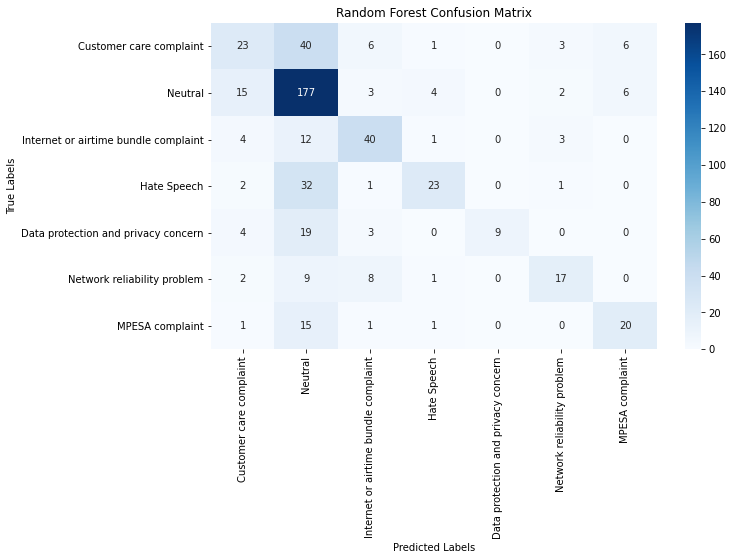

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Fit the model on training data
rf_model.fit(X_train, y_train)

# 3. Predict on test data
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy Score:", accuracy_rf)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# 5. Plot the confusion matrix
labels = y.unique().tolist()  # Use your actual label list if you have one
cm = confusion_matrix(y_test, y_pred_rf, labels=labels)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
